In [20]:
# To get all the directories correct the directory must be the root directory of the PEPSDI-cloned file 
cd("/home/sebpe/Dropbox/PhD/Projects/PEPSDI")

# Required packages for formulating a model and do inference 
using Distributions # For placing priors 
using Random # For setting seed 
using LinearAlgebra # For matrix operations 
using Plots # For plotting 
using Printf # For printing formatted 
using DelimitedFiles # For readin files
tmp = push!(LOAD_PATH, pwd() * "/Code") # Push PEPSDI into load-path 
using PEPSDI # Load PEPSDI 

# PEPSDI tutorial 

This notebook is complementary to the section *A tutorial on constructing a single-cell dynamic model* in the supplementary of the manuscript. That part was considered with construction of a single-cell dynamic model, this part will cover how inference can be performed using PEPSDI. 

The model considered is a gene-network model model regulated by the circadian-clock:


$\mathcal{R}_1 \quad \phi \xrightarrow[]{c_1 \big(1 + \mathrm{sin}(\omega t) \big)} \mathrm{mRNA} $

$\mathcal{R}_2 \quad \mathrm{mRNA} \xrightarrow[]{c_2} \phi$

$\mathcal{R}_3 \quad \mathrm{mRNA} \xrightarrow[]{c_3} \mathrm{Protein}$

$\mathcal{R}_4 \quad \mathrm{Protein} \xrightarrow[]{c_4} \phi $

The model consists of two states (mRNA, Protein), and four reactions with associated rate-constants $\mathbf{c} = (c_1,c_2,c_3 c_4)$.The circadian clock, modelled as a sine-function with a period of 24 hours, regulates the transcriptions activity $c_1$. 

The inference assumes that data is observed for 40 individuals over a period of 48 hours:

ADD IMAGE!

To model extrinsic noise, we assume that $\mathbf{c}$ follows a log-normal distribution; $\mathbf{c} \sim  \mathcal{LN} (\mu, D(\tau)\Phi D(\tau))$ where $D(\tau)$ is a diagonal matrix with the standard-devation (scale) vector $\tau$ on the diagonal and $\Phi$ is a correlation matrix. For computational speed in tutorial we assume tat $\Phi$ is diagonal (no correlation). Furthermore, for computational reasons we model intrinsic noise via the approximate tau-lepaing(Poisson) simulator. For how to use use the exact Extrande-simulator, and a non-diagonal $\Phi$, see the Clock_model-notebook.

The reason we use a non-diagonal correlation matrix, and an approximate stochastic simulator, in this tutorial is to showcase how assumptions can affect the inference. Furthermore, we also want the user to be able to run this notebook sufficently fast.  



## Defining the clock tau-leaping (Poisson) model 

A tau-lepaing-model, here called Poisson-model (it relies on Poisson-random numbers), is defined by a propensity (hazard) vector $\mathbf{h}$ which contains the propensites for each reaction, a stoichiometry matrix $\mathbf{S}$ (describes how the molecules interact in each reaction), the observation model $y_\mathrm{mod} = h(x, t)$ and lastly the error model, $y_{obs} = g(\epsilon)$, $\epsilon \sim \pi_{\epsilon}(\xi)$. To perform inference all these have to be defined. That is, an Extrande-model consists of a:

* Function for the propensity vector (h-vector)
* Function for calculating the maximum value of the propensity vector between $t_{start} \rightarrow t_{end}$
    * This is required by the Extrande-algorithm 
* A stoichiometry matrix
* Function to calculate initial values 
    * Since the initial values can be unknown providing an initial value functions makes it possible to infer initial values 
* Function for the observation y (h)
* Function for the probability of observing y (g)



In [2]:
# The drift vector need to have arguments u, h_vec, p, t 
# u : current state-values 
# h_vec : propensity vector (not allocating new h_vec is computationally efficient)
# p : unknown model-quantites. p.c gives acces to individual parameters c, 
#     while p.kappa gives acces to cell-constants for multi-individual inference.  
# t : current time-value 
function clock_h_vec!(u, h_vec, p, t)
    c = p.c
    const_term = 0.2617993877991494
    h_vec[1] = c[1] * (1 + sin(const_term * t))
    h_vec[2] = c[2] * u[1]
    h_vec[3] = c[3] * u[1]
    h_vec[4] = c[4] * u[2]    
end


# The initial-value function needs to have the arguments u0, p. Note 
# for tau-leaing(Posson)-model the initial values must be a positive integer. 
# u0 : vector with initial values (not allocating new du is efficient)
# p : as above (this allows initial values to be inferred)
function clock_u0!(u0::T1, p) where T1<:Array{<:Int32, 1} 
    u0[1] = 0
    u0[2] = 0
end


# The observation function y = g(X, p) must always have the arguments 
# y_mod, u, p, t
# y_mod : vector with model values at time t 
# u : state-values at time t
# p : as above (this allows y to depend on the parameters)
# t : current time-value 
function clock_h(y_mod, u, p, t)
    y_mod[1] = u[2]
end


# The function for the probability to observe y_mod must always have the arguments 
# y_obs, y_mod, error_param, t, dim_obs. 
# y_obs : vector with observed values at time t (dimension = dim_obs)
# y_obs : vector with model values at time t (dimension = dim_obs)
# error_param : vector with error-parameters xi 
# t : current t-value 
# dim_obs, dimension of the observation vector y. 
function clock_g(y_obs, y_mod, error_param, t, dim_obs)

    # Since y_obs ~ N(y_mod, xi^2) the likelihood can be calculated 
    # via the normal distribution. Perform calculations on log-scale 
    # for stabillity. 

    prob::FLOAT = 0.0
    error_dist = Normal(0.0, error_param[1])
    diff = y_obs[1] - y_mod[1]
    prob = logpdf(error_dist, diff)
    
    return exp(prob)
end

# Setting up stoichiometry matrix 
S_matrix = convert(Array{Int16, 2}, [-1 0; 0 -1; 1 0; 0 1]) # For computational reasons the matrix must be Array{Int16, 2}}]

# Set up the Poisson(tau-leaping)-model 
my_model = PoisonModel(clock_h_vec!, 
                       clock_u0!, 
                       clock_h, 
                       clock_g, 
                       UInt16(2), # Number of model species (mRNA, Protein), note must be UInt16 type
                       UInt16(1), # Number of observed outputs (only Protein)
                       UInt16(4), # Number of model reactions (four) 
                       S_matrix) # stoichiometry matrix 

PoisonModel{typeof(clock_h_vec!),typeof(clock_u0!),typeof(clock_h),typeof(clock_g),UInt16,Array{Int16,2}}(clock_h_vec!, clock_u0!, clock_h, clock_g, 0x0002, 0x0001, 0x0004, Int16[-1 0; 0 -1; 1 0; 0 1])

## Defining inference options 

When we have a model we can perform the inference. However, before performing the inference we must specify inference options. These are 

* Distribution described by the population parameters $\eta$; $\mathbf{c}_i \sim \pi(\mathbf{c_i} | \eta)$
    * Since we assume that $\mathbf{c} \sim \mathcal{LN}\big(\mu, D(\tau) \mathbf{I} D(\tau) \big)$ our population parameters are $\eta = (\mu, \tau)$ (they describe the distribution of the cell-individual parameters $\mathbf{c}$). Note $\mathbf{I}$ is the identity matrix.  
* Priors for the population parameters $\eta$, cell-constant parameter $\kappa$ and measurement error-parameters $\xi$.
    * Almost any distribution in the Julia distributions pacakge can be used for placing priors. 
    * Since the model does not have any cell-constant parameters $\kappa$, or correlation $\Phi$ we do not have to use a priors here. 
* If the population, individual, and cell-constants parameters are inferred on log-scale, and if the parameters are constrained to be positive 
    * Performing inference on the log-scale means to infer log(c) instead of $\mathbf{c}$. This can help explore the posterior more efficiently  (which is why we do it below) inference perspective. 
* Which particle filter to use for pseudo-marginal inference 
    * For Poisson(tau-leaping)-model step-length when solving the model most be provided (since we cannot solve the model analytically) 
    * For Poisson-models the particles can also be correlated, this is often more computatationally efficient. 

* If using PEPSDI-runnning option 2, how much $\kappa, \xi$ should vary between cells; $(\kappa_i, \xi_i) \sim \mathcal{N}\big( (\kappa_{pop}, \xi_{pop} ),  \epsilon \mathbf{I} \big), ε \ll 1 $ 
* Which adaptive mcmc-proposals scheme to propose $\kappa$, $\xi$ and $\mathbf{c}_i$ with.    
    * As noted in the paper, we found the RAM-sampler to be efficient. Thus, we use it below.  
* Location of data-file with observed data and where to save the results 

Since PEPSDI running option 2 (where $\kappa, \xi$ are allowed to vary weakly between cells) is fast we use it below. 



In [3]:
# Prior for population parameters η = (μ, τ). Note, the priors can be almost any univariate distribution, 
# but they most be provided as arrays. 
prior_mu = [Normal(0.0, 2.0), 
            Normal(2.0, 5.0), 
            Normal(0.0, 5.0), 
            Normal(0.0, 5.0)]
prior_tau = [truncated(Cauchy(0.0, 2.5), 0.0, Inf), 
            truncated(Cauchy(0.0, 2.5), 0.0, Inf), 
            truncated(Cauchy(0.0, 2.5), 0.0, Inf), 
            truncated(Cauchy(0.0, 2.5), 0.0, Inf)]

# Prior for strength of measurement error ξ must also be array 
prior_xi = [Normal(2.0, 0.5)]

# Choosing a particle filter for the Pseudo-marginal inference. Below we use the bootstrap EM-filter with correlation 
# which often requires fewer particles -> faster inference. 
# Overall, the filter requires the step-length (we take 0.2) when simulating the model the, and the correlation 
# level between particles (0.99-0.999 is a good choice)
dt = 0.2  
rho = 0.999 # Strong correlation to reduce number of particles 
filter_opt = init_filter(BootstrapPois(), dt, rho=rho) # For other filters, see the other examples

# Set inference option for the population parameters, and cell-constant parameters ĸ, ξ. These options 
# are stored in pop_param_info, which is a struct that stores the provided priors, and information 
# if parameters should be positive and/or inferred on log-scale. Below we state that ξ should be inferred 
# as positive. By default, ξ is not inferred on the log-scale. Full documentation for the function 
# can be found in the code. 
pop_param_info = init_pop_param_info(prior_mu, 
                                     prior_tau, 
                                     prior_xi, 
                                     pos_pop_sigma = true) # ξ inferred to be positive (and default not on log-scale)

# Set inference options for the cell-individual parameters c_i. These options are stored in ind_param_info, 
# which is a struct that stores initial-values to use (here we use the mean of the prior, can also use median, 
# random, or provide array ,see other examples), number of individual parameters and parameters should be 
# positive and/or inferred on log-scale. Below we infer the parameters on log-scale, and do not enforce the 
# log-parameters to be positive. 
ind_param_info = init_ind_param_info("mean",         # Starting value for pilot run is mean of prior
                                     4,               # Number of individual parameters  
                                     log_scale=true,  # Individual parameters inferred on log-scale 
                                     pos_param=false) # Individual parameters not constrained to be positive 

# Define the distributions for η. Since we assume that c_i follow a log-normal with diagonal covariance matrix, 
# we have that log(c_i) (which we infer) follow a multivariate normal with diagonal covariance matrix. This 
# is one of the population samplers avaible in PEPSDI (all options are in the Population_samplers.jl file, 
# and for example also see the Clock_model notebook)
pop_sampler_opt = init_pop_sampler_opt(PopNormalDiag(), n_warm_up=50) 

# Since we run PEPSDI option 2 we assume that ξ ~ N(ξ_pop, εI). Here we define ε to be 0.01  
kappa_sigma_sampler_opt = init_kappa_sigma_sampler_opt(KappaSigmaNormal(), variances = [0.01]) # ξ_pop with ε = 0.01 

# Both ci, and ĸi,ξi are (as dicussed in the paper) proposed by adaptive mcmc-proposals. These propose new parameters on 
# the form ci_new = ci_old + N(0, Σ). PEPSDI has three schemes to adaptively tune the covariance Σ, and as seen in the 
# paper the RAM-scheme perfoms well. Thus we use it below. To avoid taking to large initial steps we provide a starting 
# Σ = diag(0.1) for each sampler (for all options see init_mcmc in the code). 
cov_mat_ci = diagm([0.1, 0.1, 0.1, 0.1])
cov_mat_kappa_sigma = diagm([0.1])
mcmc_sampler_ci = init_mcmc(RamSampler(), ind_param_info, cov_mat=cov_mat_ci)
mcmc_sampler_kappa_sigma = init_mcmc(RamSampler(), pop_param_info, cov_mat=cov_mat_kappa_sigma)

# PEPSDI needs a data-file, and a location where to store the inference (and intermediate) results. 
# These file-locaitons are all stored in a struct created by init_file_loc. Note, all results are 
# stored in a directory named intermediate. 
path_data = pwd() * "/Intermediate/Simulated_data/SSA/Multiple_ind/Clock/Clock.csv"
# Multiple_ind = true -> stored in intermediate under Multiple_individual folder
file_loc = init_file_loc(path_data, "Example/Clock_model_tut", multiple_ind=true)


As cauchy distribution is used will change to median for init-param


FileLocations{Array{String,1},Array{Float64,1},Array{Int64,1}}("/home/sebpe/Dropbox/PhD/Projects/PEPSDI/Intermediate/Simulated_data/SSA/Multiple_ind/Clock/Clock.csv", "Example/Clock_model_tut", "/home/sebpe/Dropbox/PhD/Projects/PEPSDI/Intermediate/Multiple_individuals/Example/Clock_model_tut", [""], Float64[], [1])

## Perform pilot run 

To perform efficient inference, we have to pay close attention the steps in the PEPSDI algorithm that rely on pseudo-marginal inference. The pseduo-marginal inference employs particle filters, which by propagating particles estimate the likelihood of observing the data. We can choose the number of particles, but, typically we want to use as few particles as possible. PEPSDI has tuning algorithms for this, but they require that a pilot run is performed. Thus the tuning approach used in PEPSDI is to first run a pilot-run to end up at a central location in the posterior distribution. From this central location the particles can be tuned according to certain criteria (see paper supplementary 5.2). 

To acheive an efficient pilot run (that arrives at a central posterior locaiton) we typically need to have many particles. Else, the pilot-run (MCMC-chain) can get stuck.  In PEPSDI, as seen below, the number of particles, samples, and starting location for the pilot run can be choosen. 

After the pilot-run is finished, the central-posterior locaiton values for the parameters $(\mathbf{c}^{(i)}, \kappa, \xi, \eta)$ are written to disk, alongside the number of particles to use for each individual. Moreover, since the adaptive mcmc-proposals are tuned during the pilot-run, the tuned options are written. The results from the pilot run is stored in *Intermediate/Multiple_individual/Name_in_file_loc* under a pilot-run ID (e.g the first pilot run gets id 1). To avoid having to re-run a pilot (if wanting to re-tune the particles) PEPSDI further writes the pilot-run options to disk. All these options (adpative mcmc-parameters, parameter-values etc) can then be used to launch the main run from a good starting location. 

Note that tuning can take a while (since a tau-leaping model is not optimal for this kind of scenario). This part does not have to be run (as all options are stored on the GitHub). 


In [4]:
# Set up options for pilot-run. The options are stored in a struct that stores information regarding 
# parameters (from pop_param_info), number of particles to use in pilot-run, number of samples in the 
# pilot run, the correlation level rho to tune the particles for (tuning criteria depends on rho), 
# number of times to run the tuning scheme (50 often works well), and the ability to set initial 
# values for any parameters (if not provided, the mean of the prior is used). 

tune_part_data = init_pilot_run_info(pop_param_info, # Population parameter information 
                                     n_particles_pilot=1000, # Number of particles per individual in pilot-run 
                                     n_samples_pilot=5000,  # Number of samples pilot-run  
                                     rho_list=[0.999],      # Correlation level pilot-run 
                                     n_times_run_filter=50, # Number of times to run filter when tuning 
                                     init_mean=log.([3.0, 30.0, 1.5, 1.5])) # Initial values for μ pilot run 

# Tune particles for PEPSDI running option 2 (where ĸ,ξ weakly vary between cells)
tune_particles_opt2(tune_part_data, pop_param_info, ind_param_info, 
        file_loc, my_model, filter_opt, mcmc_sampler_ci, mcmc_sampler_kappa_sigma, pop_sampler_opt, kappa_sigma_sampler_opt)

As cauchy distribution is used will change to median for init-param
Starting tuning of particles using alternative sampler
Pilot run already existsTuning particles for rho = 0.999
[0.0, 2.0, 0.0, 0.0]
[1.0858736942638796 3.013083452657842 0.7996228223347661 0.39381170605227844]
[110, 160, 260, 210, 50, 80, 260, 160, 210, 110, 310, 90, 410, 100, 610, 160, 260, 2010, 260, 60, 90, 100, 110, 260, 110, 210, 710, 40, 260, 260, 210, 210, 360, 70, 1260, 210, 160, 80, 50, 260]
Done


### Closer look at where pilot-run results are stored 

As mentioned above, the central-posterior location values for the parameters $(\mathbf{c}^{(i)}, \kappa, \xi, \eta)$ are written to disk, alongside with adaptive-mcmc options and the number of particles. When writing to disk we decompose $\eta$ as; $\eta = (\mu, \tau, \Phi)$ = (mean, scale, corr). 

As seen below, these results are stored in CSV-file under a folder with an experimental id (named Exp_id*i*, where *i* is the id for said pilot-run). Moreover, the options used for the pilot run (initial-values, pilot-run samples and particles) are stored in the *Pilot_info.csv*-file. Overall, each pilot-run is associated with an experimental id *i* (integer), and by providing this ID to the main run, the main-run is initialised from said pilot-run. 

In [27]:
# Results from inference are stored in */Intermediate/Multiple_individuals/Clock_model_tut*, where  
# the last part is the model name provided in init_file_locations. Further, the result is here stored 
# in sub-folder with indicates the adaptive mcmc-scheme used. 
path_inference_results = pwd() * "/Intermediate/Multiple_individuals/Example/Clock_model_tut/Ram_sampler"
println("Listing files shows that there is a folder for pilot-result")
println("Files = ", readdir(path_inference_results))
println()

# Check the pilot-results 
path_pilot = path_inference_results * "/Pilot_run_data_alt/"
println("In this folder we can see that there is an option file:")
println("Files = ", readdir(path_pilot))
println()

# Check the pilot-info file 
a = readdlm(path_pilot * "Pilot_info.csv")[1:2]
println("As seen, the pilot-info file stores options for the pilot-run")
println("Row 1 file:", a[1, :])
println("Row 2 file:", a[2, :])
println()

# Check what is stored for pilot-run 
println("Checking pilot-run data folder for id 1 (first pilot run)")
println("Files = ", readdir(path_pilot * "Exp_tag1"))
println("These files contain central-posterior locations, and adaptive mcmc-options + tuned particle numbers.")

Listing files shows that there is a folder for pilot-result
Files = ["Npart1000_nsamp5000_corr0.999_exp_id1_run1", "Pilot_run_data_alt"]

In this folder we can see that there is an option file:
Files = ["Exp_tag1", "Pilot_info.csv"]

As seen, the pilot-info file stores options for the pilot-run
Row 1 file:Any["mean1,mean2,mean3,mean4,scale1,scale2,scale3,scale4,sigma1,n_samples,n_particles,id"]
Row 2 file:Any["1.0986122886681098,3.4011973816621555,0.4054651081081644,0.4054651081081644,2.4999999999999996,2.4999999999999996,2.4999999999999996,2.4999999999999996,2.0,5000.0,1000.0,1.0"]

Checking pilot-run data folder for id 1 (first pilot run)
Files = ["Corr.csv", "Ind.csv", "Kappa_sigma.csv", "Mcmc_param", "Mean.csv", "Scale.csv", "Tune_particles"]
These files contain central-posterior locations, and adaptive mcmc-options + tuned particle numbers.


## Perform main run 

As mentioned above, it is good to start the main run from a pilot-run. By providing the id *i* of a pilot-run PEPSDI will automatically read all the options from disk. Here, we provide exp_tag = 1 to use pilot run 1. 

Below, we take 5000-samples for computational-reasons, albeit, for a real inference run more samples are recomended (as in the paper). 

In [28]:
exp_id = 1 # We use pilot-run with id 1 to perform inference 
n_samples = 5000 # Use 5,000 samples to avoid to long run-time. 

# This function runs PEPSDI with option2, where ξ and ĸ vary weakly between cells. 
tmp = run_PEPSDI_opt2(n_samples, pop_param_info, ind_param_info, file_loc, my_model, 
    filter_opt, mcmc_sampler_ci, mcmc_sampler_kappa_sigma, pop_sampler_opt, kappa_sigma_sampler_opt, pilot_id=exp_id)

println("Done")

[0.0, 2.0, 0.0, 0.0]
[1.0858736942638796 3.013083452657842 0.7996228223347661 0.39381170605227844]
Starting to calculate likelihood
Log-likelihood starting value = -8684.536


Running sampler...100%|█████████████████████████████████| Time: 1:54:49m


["c1", "c2", "c3", "c4", "id"]
Running posterior visual check...Running pvc none-quantile
Running pvc quantile
done
Done


## Plotting the result 

By plotting the inference results, we see that, unlike the manuscript, we have problems with $(\mu_2, \mu_4)$. This is because we use tau-lepaing simulator instead of Extrand to model intrinsic noise, and we do not account for correlation (diagonal $\Phi$). To see how to add these, see the clock-notebook under examples. 

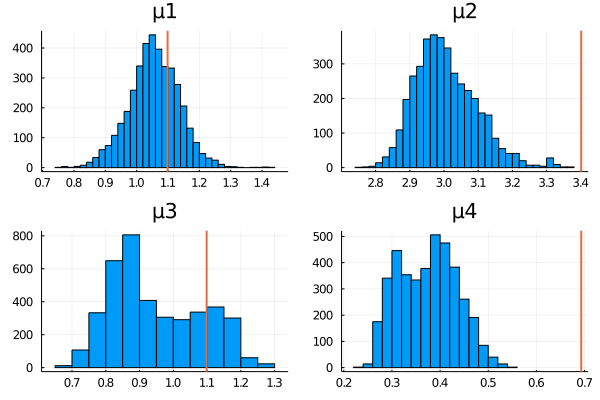

In [30]:
mcmc_chains = tmp[1]

p1 = histogram(mcmc_chains.mean[1, 1000:end], title = "µ1", label=false)
vline!(log.([3.0]), lw = 2, label=false)
p2 = histogram(mcmc_chains.mean[2, 1000:end], title = "µ2", label=false)
vline!(log.([30.0]), lw = 2, label=false)
p3 = histogram(mcmc_chains.mean[3, 1000:end], title = "µ3", label=false)
vline!(log.([3.0]), lw = 2, label=false)
p4 = histogram(mcmc_chains.mean[4, 1000:end], title = "µ4", label=false)
vline!(log.([2.0]), lw = 2, label=false)

l = @layout [a b; c d]
plot(p1, p2, p3, p4, layout = l)

## Saving results 

Upon finishing inference, PEPSDI writes the chains for $\eta = (\mu, \tau, \Phi)$, $\kappa$, $\xi$ and $c^{(i)}$ to disk. Similar to the pilot-run, results are stored in */Intermediate/Multiple_individuals/Clock_model_tut*, where the last part is the model name provided in *init_file_locations*.

In this directory, the results are stored as csv-file, under a folder that states the number of samples (n_samp), particle correlation level (corr), pilot run id (exp_id) and which run (in case the inference is run repedetely). The folder is also tagged with the particles (relevant where the user does not rely on a pilot-run to tune the particles). For the example here, the result is stored in: *Npart1000_nsamp5000_corr0.999_exp_id1_run1*. Inside this folder,  there are the chains for $\mu$ (Mean.csv), $\tau$ (Scale.csv), $(\kappa, \xi)$ (Kappa_sigma.csv) and $c^{(i)}$ (Ind_param.csv). 